## Importing PWE and other essentials

In [1]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
import numpy as np

In [2]:
%load_ext PWE_NB_Extension

## Stable Marriage Problem

https://en.wikipedia.org/wiki/Stable_marriage_problem

In particular, we are concerned with a variant of the problem (SMTI) where the preference lists can be incomplete and there might be ties over a subset of the members of the other sex. Staying single is therefore an option (sometimes a necessity).

We present a small use-case here with 2 men (M1, M2) and 3 women (W1, W2, W3) where the preferences are as follows:

M1 -> {W1}, {W2, W3}, {}

M2 -> {W2}, {W1}

W1 -> {M1, M2}, {}

W2 -> {M1}, {}

W3 -> {M2}, {M1}, {}

##### We encode this as follows:

In [3]:
%%clingo --donot-run --donot-display_input -lci clingo_rules
%asp_loadfiles clingo_files/smti.lp4

%% PREFERENCES:

% M1 -> {W1}, {W2, W3}, {}
% M2 -> {W2}, {W1}
% W1 -> {M1, M2}, {}
% W2 -> {M1}, {}
% W3 -> {M2}, {M1}, {}

%% ASSOC. COSTS
% schema cost(BEARER, MATCH, COST)

cost(m1, w1, 1).
cost(m1, w2, 2).
cost(m1, w3, 2).
cost(m1, m1, 3).

cost(m2, w2, 1).
cost(m2, w1, 2).
cost(m2, m2, 2).

cost(w1, m1, 1).
cost(w1, m2, 1).
cost(w1, w1, 2).

cost(w2, m1, 1).
cost(w2, w2, 2).

cost(w3, m2, 1).
cost(w3, m1, 2).
cost(w3, w3, 3).


%% RULES

% schema accept(PERSON1, PERSON2)
% schema manpropose(MAN_PROPOSER, WOMAN_PROPOSEE)
% schema womanpropose(MAN_PROPOSEE, WOMAN_PROPOSER)

accept(X, Y) :- manpropose(X, Y), womanpropose(X, Y).
manpropose(m1, w1).
manpropose(m1, w2) :- not accept(m1, w1), not accept(m1, w3).
manpropose(m1, w3) :- not accept(m1, w1), not accept(m1, w2).
accept(m1, m1) :- not accept(m1, w1), not accept(m1, w2), not accept(m1, w3).
manpropose(m2, w2).
manpropose(m2, w1) :- not accept(m2, w2), not accept(m2, m2).
accept(m2, m2) :- not accept(m2, w2), not accept(m2, w1).
womanpropose(m1, w1) :- not accept(m2, w1).
womanpropose(m2, w1) :- not accept(m1, w1).
accept(w1, w1) :- not accept(m1, w1), not accept(m2, w1).
womanpropose(m1, w2).
accept(w2, w2) :- not accept(m1, w2).
womanpropose(m2, w3).
womanpropose(m1, w3) :- not accept(m2, w3).
accept(w3, w3) :- not accept(m1, w3), not accept(m2, w3).

##### Using clingo, we get 3 PWs:

In [4]:
filter_str = '#show accept/2.'

In [5]:
%clingo -l clingo_rules filter_str --run --donot-display_input

Output:


'Answer: 1\naccept(m2,w1) accept(m1,w2) accept(w3,w3)\nAnswer: 2\naccept(m2,w1) accept(m1,w3) accept(w2,w2)\nAnswer: 3\naccept(m1,w1) accept(m2,m2) accept(w3,w3) accept(w2,w2)\nSATISFIABLE\n\nModels       : 3\nCalls        : 1\nTime         : 0.002s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

In [6]:
clingo_soln, meta_data = run_clingo(clingo_rules=clingo_rules)

In [7]:
meta_data

{'temporal_dec': {},
 'attr_def': {'cost_3': ['BEARER', 'MATCH', 'COST'],
  'accept_2': ['PERSON1', 'PERSON2'],
  'manpropose_2': ['MAN_PROPOSER', 'WOMAN_PROPOSEE'],
  'womanpropose_2': ['MAN_PROPOSEE', 'WOMAN_PROPOSER']},
 'graphviz': {'graph': {'graph_type': 'undirected', 'styles': []},
  'node': {},
  'edge': {}}}

##### Next we load these PWs into PWE

In [8]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo')

Number of Models: 3


The following atom types were parsed:

In [9]:
list(map(lambda x: x.__dict__, rel_schemas))

[{'relation_name': 'womanpropose_2',
  'arity': 2,
  'r_id': 0,
  'meta_data': {'attr_def': ['MAN_PROPOSEE', 'WOMAN_PROPOSER']}},
 {'relation_name': 'manpropose_2',
  'arity': 2,
  'r_id': 1,
  'meta_data': {'attr_def': ['MAN_PROPOSER', 'WOMAN_PROPOSEE']}},
 {'relation_name': 'cost_3',
  'arity': 3,
  'r_id': 2,
  'meta_data': {'attr_def': ['BEARER', 'MATCH', 'COST']}},
 {'relation_name': 'accept_2',
  'arity': 2,
  'r_id': 3,
  'meta_data': {'attr_def': ['PERSON1', 'PERSON2']}}]

In [10]:
pw_rels_dfs.keys()

dict_keys(['womanpropose_2', 'manpropose_2', 'cost_3', 'accept_2'])

The costs of the matchings are presented here. These are consistent among all PWs by design.

In [11]:
pw_rels_dfs['cost_3']

,pw,BEARER,MATCH,COST
0,1,m1,w1,1
1,1,m1,w2,2
2,1,m1,w3,2
3,1,m1,m1,3
4,1,m2,w2,1
5,1,m2,w1,2
6,1,m2,m2,2
7,1,w1,m1,1
8,1,w1,m2,1
9,1,w1,w1,2


The accept_2 relation contains the matchings/marriages of the PWs

In [12]:
pw_rels_dfs['accept_2']

,pw,PERSON1,PERSON2
0,1,m2,w1
1,1,m1,w2
2,1,w3,w3
3,2,m2,w1
4,2,m1,w3
5,2,w2,w2
6,3,m1,w1
7,3,m2,m2
8,3,w3,w3
9,3,w2,w2


##### We define a simple visualization function to better understand these matchings and associated costs:

In [13]:
import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

def visualize_matchings(accept_df, pw_id):
    G = nx.Graph()
    accept_df = accept_df[accept_df['pw'] == pw_id]
    people_list = list(np.unique(accept_df[['PERSON1', 'PERSON2']].values))
    men_list = list(filter(lambda x: x[0] == 'm', people_list))
    women_list = list(filter(lambda x: x[0] == 'w', people_list))
    G.add_nodes_from(men_list, bipartite=0, style='filled', colorscheme='pastel19', 
                     fillcolor=4, color='black', fontname='Helvetica')
    G.add_nodes_from(women_list, bipartite=1, style='filled', colorscheme='pastel19', 
                     fillcolor=5, color='black', fontname='Helvetica')
    pos = nx.drawing.layout.bipartite_layout(G, men_list)
    G.graph['layout'] = 'neato'
    G.graph['label'] = "Matching-{}".format(pw_id)
    for node in G.nodes: 
        G.nodes[node]['pos'] = "{},{}!".format(pos[node][0], pos[node][1])
    for i, row in accept_df.iterrows():
        if row['PERSON1'] != row['PERSON2']:
            G.add_edge(row['PERSON1'], row['PERSON2'])
        else:
            G.nodes[row['PERSON1']]['color'] = '#ff0000'
    return G

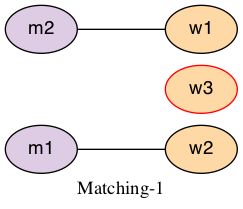

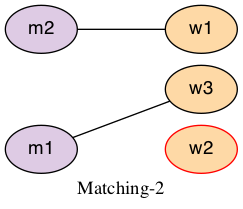

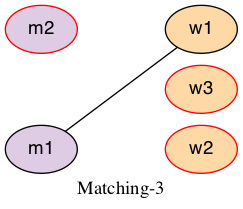

In [14]:
matching_vizs = [draw(visualize_matchings(pw_rels_dfs['accept_2'], pw_id=i)) for i in range(1, len(pw_objs)+1)]
display(*matching_vizs)

##### We define a simple function to calculate the cost of the matchings to each person in each of the PWs:

In [15]:
def calculate_costs(dfs, rels, pw_id):
    
    def calc_costs_helper(pairings_df, costs_df, person):
        
        partner = None
        if not pairings_df[pairings_df['PERSON1'] == person].empty:
            partner = pairings_df[pairings_df['PERSON1'] == person].iloc[0]['PERSON2']
        elif not pairings_df[pairings_df['PERSON2'] == person].empty:
            partner = pairings_df[pairings_df['PERSON2'] == person].iloc[0]['PERSON1']
        cost = None
        if not costs_df[(costs_df['BEARER'] == person) & (costs_df['MATCH'] == partner)].empty:
            cost = float(costs_df[(costs_df['BEARER'] == person) & (costs_df['MATCH'] == partner)].iloc[0]['COST'])
        elif not costs_df[(costs_df['MATCH'] == person) & (costs_df['BEARER'] == partner)].empty:
            cost = float(costs_df[(costs_df['MATCH'] == person) & (costs_df['BEARER'] == partner)].iloc[0]['COST'])
        
        return cost
    
    pairings_df = dfs['accept_2']
    pairings_df = pairings_df[pairings_df['pw'] == pw_id]
    
    costs_df = dfs['cost_3']
    costs_df = costs_df[costs_df['pw'] == pw_id]
    
    people_list = list(np.unique(pairings_df[['PERSON1', 'PERSON2']].values))
    
    people_cost = {person: calc_costs_helper(pairings_df, costs_df, person) for person in people_list}
    
    return people_cost

In [16]:
costs_by_pw = {pw_id: calculate_costs(pw_rels_dfs, rel_schemas, pw_id) for pw_id in range(1, len(pw_objs)+1)}

#### These are the "costs" for each person in these PWs

In [17]:
costs_by_pw

{1: {'m1': 2.0, 'm2': 2.0, 'w1': 1.0, 'w2': 1.0, 'w3': 3.0},
 2: {'m1': 2.0, 'm2': 2.0, 'w1': 1.0, 'w2': 2.0, 'w3': 2.0},
 3: {'m1': 1.0, 'm2': 2.0, 'w1': 1.0, 'w2': 2.0, 'w3': 3.0}}

#### However, as we know, these PWs are not equal in terms of qualities such as difference between costs to men and women (sex-ineequality cost), number of singles (cardinality cost), max cost any person has to bear (max-regret cost) and the total cost the people involved need to pay (egalitarian cost). We want to ideally minimize all these costs.

We define these costs as follows and calculate them for each of the PWs.

In [18]:
def egalitarian_cost(costs):
    return sum(costs.values())

def sex_inequality_cost(costs):
    men_cost = sum([val for key, val in costs.items() if key[0] == 'm'])
    women_cost = sum([val for key, val in costs.items() if key[0] == 'w'])
    return abs(men_cost - women_cost)

def max_regret_cost(costs):
    return max(costs.values())

def cardinality_cost(dfs, rels, pw_id):
    accept_df = dfs['accept_2']
    accept_df = accept_df[accept_df['pw'] == pw_id]
    return len(accept_df[accept_df['PERSON1'] == accept_df['PERSON2']])

Defining a utility function here:

In [19]:
def my_min(pw_to_costs_dict):
    pw_ids, costs =  list(map(np.array, list(zip(*list(pw_to_costs_dict.items())))))
    min_cost_indices = np.where(costs == costs.min())
    return list(pw_ids[min_cost_indices])

We now want to see how each PW fairs with respect to each of these metrics and which one is best at minimizing that particular cost.

In [20]:
# MINIMIZE EGALITARIAN COST (Average Regret)
eg_costs = {pw_id: egalitarian_cost(costs) for pw_id, costs in costs_by_pw.items()}
eg_cost_minimizing_pws = list(map(str, my_min(eg_costs)))
for pw_id in range(1, len(pw_objs)+1):
    print("Egalitarian Cost for PW-{} is {}".format(pw_id, eg_costs[pw_id]))
print("PW-{} minimize{} egalitarian cost.".format(','.join(eg_cost_minimizing_pws), 
                                                  's' if len(eg_cost_minimizing_pws) == 1 else ''))

Egalitarian Cost for PW-1 is 9.0
Egalitarian Cost for PW-2 is 9.0
Egalitarian Cost for PW-3 is 9.0
PW-1,2,3 minimize egalitarian cost.


In [21]:
# MINIMIZE SEX-INEQUALITY COST
sex_ineq_costs = {pw_id: sex_inequality_cost(costs) for pw_id, costs in costs_by_pw.items()}
sex_ineq_cost_minimizing_pws = list(map(str, my_min(sex_ineq_costs)))
for pw_id in range(1, len(pw_objs)+1):
    print("Sex-Inequality Cost for PW-{} is {}".format(pw_id, sex_ineq_costs[pw_id]))
print("PW-{} minimize{} sex-inequality cost.".format(','.join(sex_ineq_cost_minimizing_pws), 
                                                     's' if len(sex_ineq_cost_minimizing_pws) == 1 else ''))

Sex-Inequality Cost for PW-1 is 1.0
Sex-Inequality Cost for PW-2 is 1.0
Sex-Inequality Cost for PW-3 is 3.0
PW-1,2 minimize sex-inequality cost.


In [22]:
# MINIMIZE MAX-REGRET COST
max_regret_costs = {pw_id: max_regret_cost(costs) for pw_id, costs in costs_by_pw.items()}
max_regret_cost_minimizing_pw = list(map(str, my_min(max_regret_costs)))
for pw_id in range(1, len(pw_objs)+1):
    print("Max-Regret Cost for PW-{} is {}".format(pw_id, max_regret_costs[pw_id]))
print("PW-{} minimize{} max-regret cost.".format(','.join(max_regret_cost_minimizing_pw), 
                                                 's' if len(max_regret_cost_minimizing_pw) == 1 else ''))

Max-Regret Cost for PW-1 is 3.0
Max-Regret Cost for PW-2 is 2.0
Max-Regret Cost for PW-3 is 3.0
PW-2 minimizes max-regret cost.


In [23]:
# MINIMIZE CARDINALITY COST (Number of Singles)
cardinality_costs = {pw_id: cardinality_cost(pw_rels_dfs, rel_schemas, pw_id) for pw_id, costs in costs_by_pw.items()}
cardinality_cost_minimizing_pw = list(map(str, my_min(cardinality_costs)))
for pw_id in range(1, len(pw_objs)+1):
    print("Cardinality Cost for PW-{} is {}".format(pw_id, cardinality_costs[pw_id]))
print("PW-{} minimize{} Cardinality cost.".format(','.join(cardinality_cost_minimizing_pw), 
                                                  's' if len(cardinality_cost_minimizing_pw) == 1 else ''))

Cardinality Cost for PW-1 is 1
Cardinality Cost for PW-2 is 1
Cardinality Cost for PW-3 is 3
PW-1,2 minimize Cardinality cost.
